In [3]:

%matplotlib inline
import numpy as np
#import tools
#import grader

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import display
import time
import json
from copy import deepcopy

plt.rc('font', size=30)  # controls default text sizes
plt.rc('axes', titlesize=25)  # fontsize of the axes title
plt.rc('axes', labelsize=25)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=17)  # fontsize of the tick labels
plt.rc('ytick', labelsize=17)  # fontsize of the tick labels
plt.rc('legend', fontsize=20)  # legend fontsize
plt.rc('figure', titlesize=30)
plt.tight_layout()


def plot(V, pi):
    # plot value
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))
    ax1.axis('on')
    ax1.cla()
    states = np.arange(V.shape[0])
    ax1.bar(states, V, edgecolor='none')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Value', rotation='horizontal', ha='right')
    ax1.set_title('Value Function')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax1.yaxis.grid()
    ax1.set_ylim(bottom=V.min())
    # plot policy
    ax2.axis('on')
    ax2.cla()
    im = ax2.imshow(pi.T, cmap='Greys', vmin=0, vmax=1, aspect='auto')
    ax2.invert_yaxis()
    ax2.set_xlabel('State')
    ax2.set_ylabel('Action', rotation='horizontal', ha='right')
    ax2.set_title('Policy')
    start, end = ax2.get_xlim()
    ax2.xaxis.set_ticks(np.arange(start, end), minor=True)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    start, end = ax2.get_ylim()
    ax2.yaxis.set_ticks(np.arange(start, end), minor=True)
    ax2.grid(which='minor')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.20)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('Probability', rotation=0, ha='left')
    fig.subplots_adjust(wspace=0.5)
    display.clear_output(wait=True)
    display.display(fig)
    time.sleep(0.001)
    plt.close()


class ParkingWorld:
    def __init__(self,
                 num_spaces=10,
                 num_prices=4,
                 price_factor=0.1,
                 occupants_factor=1.0,
                 null_factor=1 / 3):
        self.__num_spaces = num_spaces
        self.__num_prices = num_prices
        self.__occupants_factor = occupants_factor
        self.__price_factor = price_factor
        self.__null_factor = null_factor
        self.__S = [num_occupied for num_occupied in range(num_spaces + 1)]
        self.__A = list(range(num_prices))


    def transitions(self, s, a):
        return np.array([[r, self.p(s_, r, s, a)] for s_, r in self.support(s, a)])

    def support(self, s, a):
        return [(s_, self.reward(s, s_)) for s_ in self.__S]

    def p(self, s_, r, s, a):
        if r != self.reward(s, s_):
            return 0
        else:
            center = (1 - self.__price_factor
                      ) * s + self.__price_factor * self.__num_spaces * (
                          1 - a / self.__num_prices)
            #print(f"center:{center}")
            
            emphasis = np.exp(
                -abs(np.arange(2 * self.__num_spaces) - center) / 5)
            #print(f"emphasis:{emphasis}")
            if s_ == self.__num_spaces:
                return sum(emphasis[s_:]) / sum(emphasis)
            return emphasis[s_] / sum(emphasis)

    def reward(self, s, s_):
        return self.state_reward(s) + self.state_reward(s_)

    def state_reward(self, s):
        if s == self.__num_spaces:
            #print("self_numspaces")
            return self.__null_factor * s * self.__occupants_factor
        else:
            #print("not numspaces")
            return s * self.__occupants_factor

    def random_state(self):
        return np.random.randint(self.__num_prices)

    def step(self, s, a):
        probabilities = [
            self.p(s_, self.reward(s, s_), s, a) for s_ in self.__S
        ]
        return np.random.choice(self.__S, p=probabilities)
    
    
    @property
    def A(self):
        return list(self.__A)

    @property
    def num_spaces(self):
        return self.__num_spaces

    @property
    def num_prices(self):
        return self.num_prices

    @property
    def S(self):
        return list(self.__S)


class Transitions(list):
    def __init__(self, transitions):
        self.__transitions = transitions
        super().__init__(transitions)

    def __repr__(self):
        repr = '{:<14} {:<10} {:<10}'.format('Next State', 'Reward',
                                             'Probability')
        repr += '\n'
        for i, (s, r, p) in enumerate(self.__transitions):
            repr += '{:<14} {:<10} {:<10}'.format(s, round(r, 2), round(p, 2))
            if i != len(self.__transitions) - 1:
                repr += '\n'
        return repr


<Figure size 640x480 with 0 Axes>

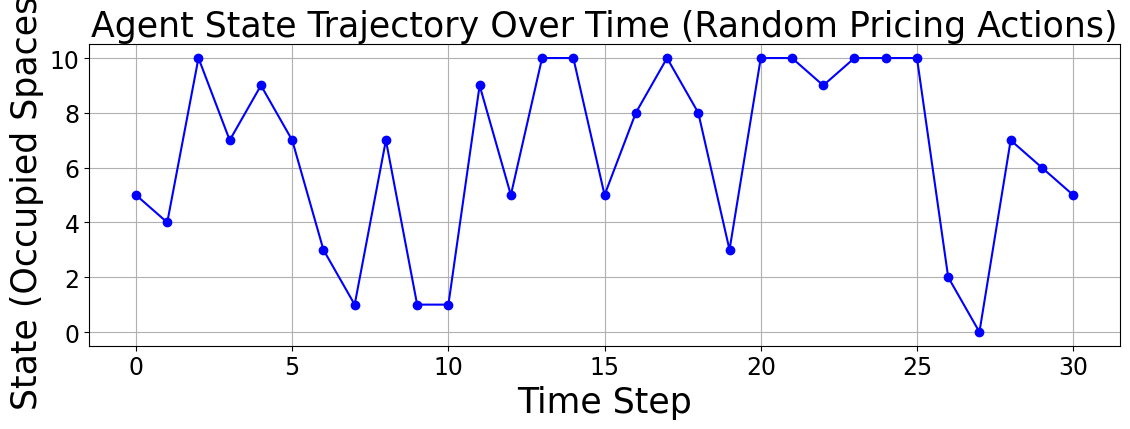

In [5]:
# --- Run a single agent trajectory with random actions ---
env = ParkingWorld(num_spaces=10, num_prices=4)
initial_state = 5
num_steps = 30

state = initial_state
trajectory = [state]

for _ in range(num_steps):
    action = np.random.choice(env.A)  # random pricing action
    next_state = env.step(state, action)
    trajectory.append(next_state)
    state = next_state


# Assume `trajectory` is a list or array of state values collected over time
trajectory_mean = np.mean(trajectory)
trajectory_variance = np.var(trajectory)

print("Mean of trajectory:", trajectory_mean)
print("Variance of trajectory:", trajectory_variance)
# --- Plot the trajectory ---
plt.figure(figsize=(12, 5))
plt.plot(range(num_steps + 1), trajectory, marker='o', linestyle='-', color='blue')
plt.title('Agent State Trajectory Over Time (Random Pricing Actions)')
plt.xlabel('Time Step')
plt.ylabel('State (Occupied Spaces)')
plt.grid(True)
plt.tight_layout()
plt.show()

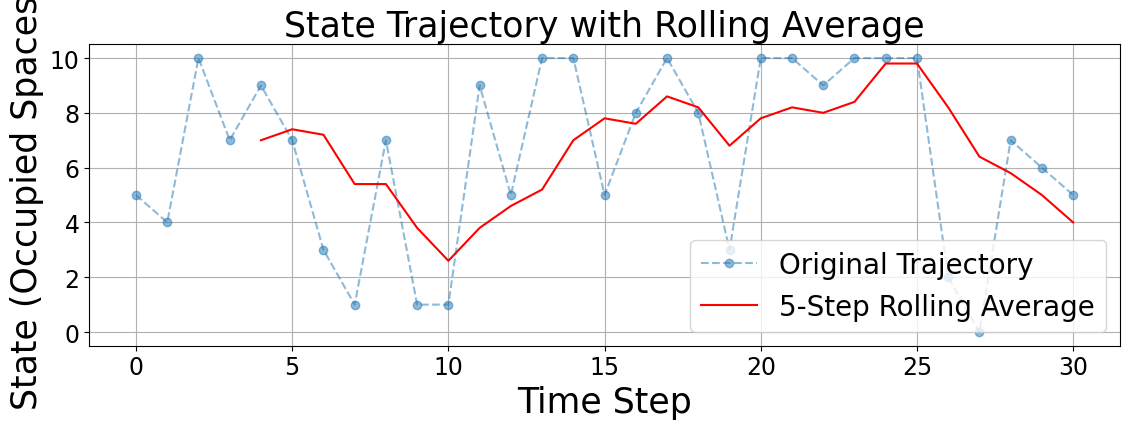

In [6]:
window_size = 5
rolling_avg = np.convolve(trajectory, np.ones(window_size) / window_size, mode='valid')

# Plot trajectory with rolling average
plt.figure(figsize=(12, 5))
plt.plot(range(len(trajectory)), trajectory, label='Original Trajectory', marker='o', linestyle='--', alpha=0.5)
plt.plot(range(window_size - 1, len(trajectory)), rolling_avg, label=f'{window_size}-Step Rolling Average', color='red')
plt.title('State Trajectory with Rolling Average')
plt.xlabel('Time Step')
plt.ylabel('State (Occupied Spaces)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



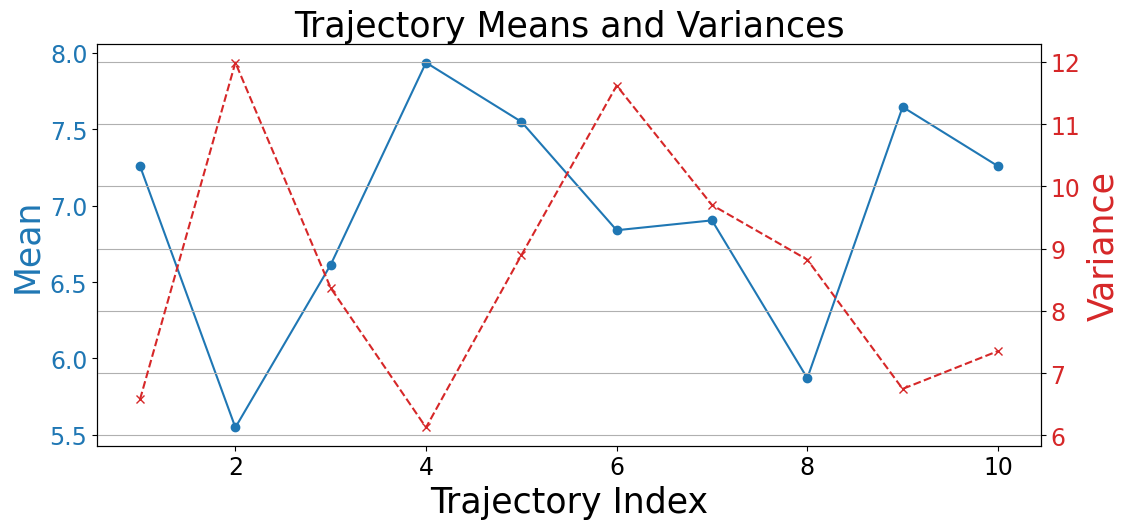

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assume ParkingWorld class is already defined and imported ---

# Initialize environment
env = ParkingWorld(num_spaces=10, num_prices=4)

# Parameters
num_trajectories = 10
num_steps = 30
initial_state = 5

# Collect mean and variance for each trajectory
trajectory_means = []
trajectory_vars = []

for _ in range(num_trajectories):
    state = initial_state
    trajectory = [state]

    for _ in range(num_steps):
        action = np.random.choice(env.A)  # random pricing action
        state = env.step(state, action)
        trajectory.append(state)

    trajectory_means.append(np.mean(trajectory))
    trajectory_vars.append(np.var(trajectory))

# --- Plot: Means and Variances ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot trajectory means
color = 'tab:blue'
ax1.set_xlabel('Trajectory Index')
ax1.set_ylabel('Mean', color=color)
ax1.plot(range(1, num_trajectories + 1), trajectory_means, marker='o', linestyle='-', color=color, label='Mean')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Trajectory Means and Variances')

# Plot trajectory variances on second y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Variance', color=color)
ax2.plot(range(1, num_trajectories + 1), trajectory_vars, marker='x', linestyle='--', color=color, label='Variance')
ax2.tick_params(axis='y', labelcolor=color)

# Finalize layout
fig.tight_layout()
plt.grid(True)
plt.show()

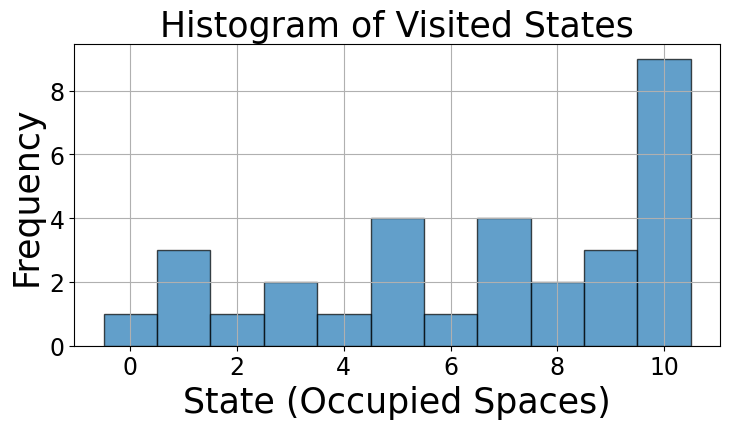

In [7]:
# Histogram of visited states
plt.figure(figsize=(8, 5))
plt.hist(trajectory, bins=np.arange(min(trajectory), max(trajectory) + 2) - 0.5, edgecolor='black', alpha=0.7)
plt.title('Histogram of Visited States')
plt.xlabel('State (Occupied Spaces)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

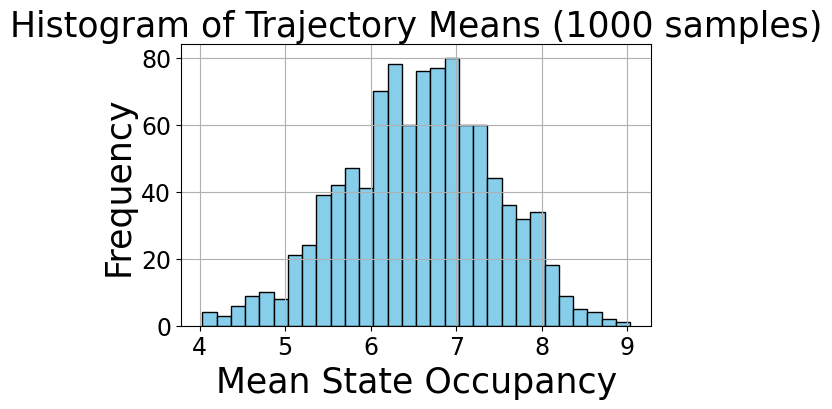

In [10]:
# Run 1000 random trajectories and histogram their means
trajectory_means = []
for _ in range(1000):
    state = 5
    trajectory = [state]
    for _ in range(30):
        action = np.random.choice(env.A)
        state = env.step(state, action)
        trajectory.append(state)
    trajectory_means.append(np.mean(trajectory))

# Plot histogram
plt.hist(trajectory_means, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Trajectory Means (1000 samples)')
plt.xlabel('Mean State Occupancy')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
greedy_policy = {
  0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 1,
  9: 3,
 10: 3
}

print(type(greedy_policy))
print(greedy_policy[9])

<class 'dict'>
3


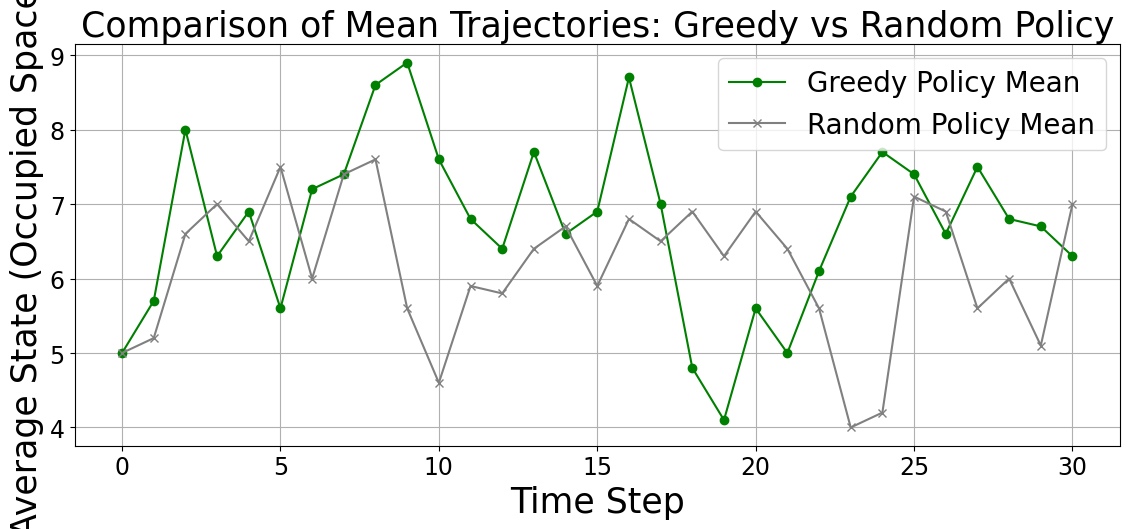

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assume ParkingWorld and greedy_policy are already defined ---

# Parameters
num_trajectories = 10
num_steps = 30
initial_state = 5

# --- Simulate Greedy Policy Trajectories ---
greedy_trajectories = []
for _ in range(num_trajectories):
    state = initial_state
    trajectory = [state]
    for _ in range(num_steps):
        action = greedy_policy[state]
        state = env.step(state, action)
        trajectory.append(state)
    greedy_trajectories.append(trajectory)
greedy_trajectories_array = np.array(greedy_trajectories)
mean_greedy = np.mean(greedy_trajectories_array, axis=0)

# --- Simulate Random Policy Trajectories ---
random_trajectories = []
for _ in range(num_trajectories):
    state = initial_state
    trajectory = [state]
    for _ in range(num_steps):
        action = np.random.choice(env.A)
        state = env.step(state, action)
        trajectory.append(state)
    random_trajectories.append(trajectory)
random_trajectories_array = np.array(random_trajectories)
mean_random = np.mean(random_trajectories_array, axis=0)

# --- Plot Comparison ---
plt.figure(figsize=(12, 6))
plt.plot(mean_greedy, label='Greedy Policy Mean', marker='o', color='green')
plt.plot(mean_random, label='Random Policy Mean', marker='x', color='gray')
plt.title('Comparison of Mean Trajectories: Greedy vs Random Policy')
plt.xlabel('Time Step')
plt.ylabel('Average State (Occupied Spaces)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.show()

In [35]:
# ---------------
# Discussion Cell
# ---------------
num_spaces = 3
num_prices = 3
env = ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
pi = np.ones((num_spaces + 1, num_prices)) / num_prices

In [41]:
print(env.reward(0,0),env.reward(0,1),env.reward(0,2),env.reward(0,3))
print(env.reward(1,0),env.reward(1,1),env.reward(1,2),env.reward(1,3))
print(env.reward(2,0),env.reward(2,1),env.reward(2,2),env.reward(2,3))
print(env.reward(3,0),env.reward(3,1),env.reward(3,2),env.reward(3,3))


0.0 1.0 2.0 1.0
1.0 2.0 3.0 2.0
2.0 3.0 4.0 3.0
1.0 2.0 3.0 2.0


In [36]:
print(f"V:{V}")
print(f"pi:{pi}") #3x4 [spaces, actions]

V:[0. 0. 0. 0.]
pi:[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]


In [26]:
pi[0] = [0.75, 0.11, 0.14]

for s, pi_s in enumerate(pi):
    for a, p in enumerate(pi_s):
        print(f'pi(A={a}|S={s}) = {p.round(2)}    ', end='')
    print()

pi(A=0|S=0) = 0.75    pi(A=1|S=0) = 0.11    pi(A=2|S=0) = 0.14    
pi(A=0|S=1) = 0.33    pi(A=1|S=1) = 0.33    pi(A=2|S=1) = 0.33    
pi(A=0|S=2) = 0.33    pi(A=1|S=2) = 0.33    pi(A=2|S=2) = 0.33    
pi(A=0|S=3) = 0.33    pi(A=1|S=3) = 0.33    pi(A=2|S=3) = 0.33    


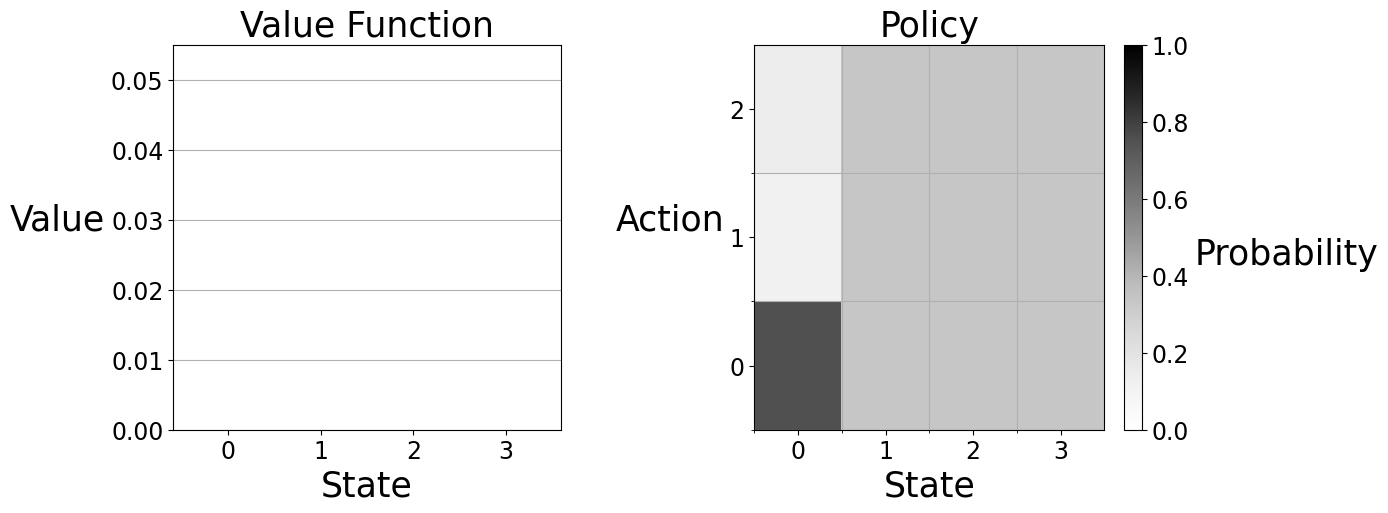

In [27]:
V[0] = 0

plot(V, pi)

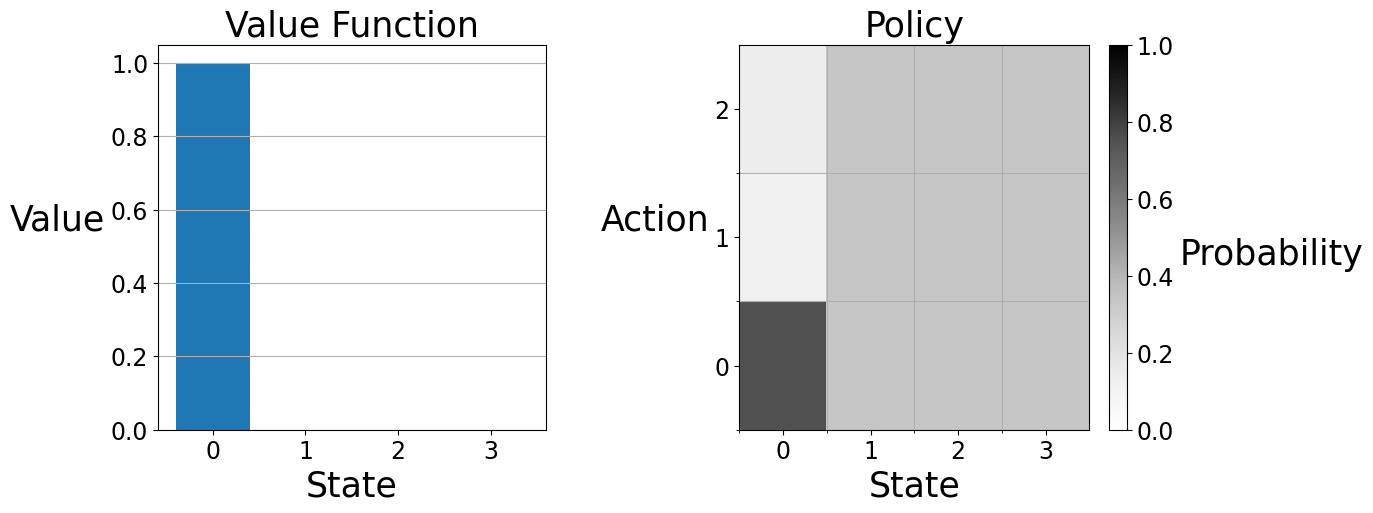

In [28]:
V[0] = 1

plot(V, pi)

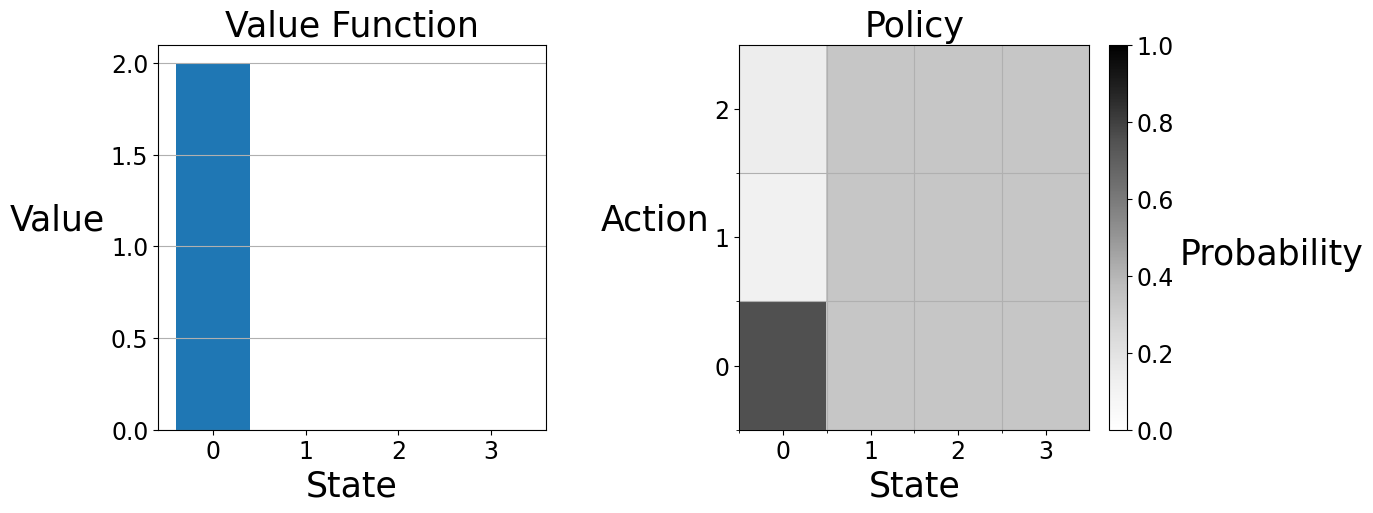

In [29]:
V[0] = 2

plot(V, pi)

We can visualize a value function and policy with the `plot` function in the `tools` module. On the left, the value function is displayed as a barplot. State zero has an expected return of ten, while the other states have an expected return of zero. On the right, the policy is displayed on a two-dimensional grid. Each vertical strip gives the policy at the labeled state. In state zero, action zero is the darkest because the agent's policy makes this choice with the highest probability. In the other states the agent has the equiprobable policy, so the vertical strips are colored uniformly.

How to access states and actions in environment


In [30]:
print(env.S)
print(env.A)

[0, 1, 2, 3]
[0, 1, 2]


## probabiity transitions between states
You will need to use the environment's `transitions` method to complete this assignment. The method takes a state and an action and returns a 2-dimensional array, where the entry at $(i, 0)$ is the reward for transitioning to state $i$ from the current state and the entry at $(i, 1)$ is the conditional probability of transitioning to state $i$ given the current state and action.

In [31]:
state = 3
action = 1
transitions = env.transitions(state, action)
transitions

p s_:0 r:1.0 s:3 a:1
else
1-self.__price_factor:0.9
self.__num_spaces:3
self.__price_factor * self.__num_spaces:0.30000000000000004
 s + self.__price_factor * self.__num_spaces:3.3
a / self.__num_prices:0.3333333333333333
1-a / self.__num_prices:0.6666666666666667
center:2.9000000000000004
emphasis:[0.55989837 0.68386141 0.83527021 0.98019867 0.8025188  0.65704682]
p s_:1 r:2.0 s:3 a:1
else
1-self.__price_factor:0.9
self.__num_spaces:3
self.__price_factor * self.__num_spaces:0.30000000000000004
 s + self.__price_factor * self.__num_spaces:3.3
a / self.__num_prices:0.3333333333333333
1-a / self.__num_prices:0.6666666666666667
center:2.9000000000000004
emphasis:[0.55989837 0.68386141 0.83527021 0.98019867 0.8025188  0.65704682]
p s_:2 r:3.0 s:3 a:1
else
1-self.__price_factor:0.9
self.__num_spaces:3
self.__price_factor * self.__num_spaces:0.30000000000000004
 s + self.__price_factor * self.__num_spaces:3.3
a / self.__num_prices:0.3333333333333333
1-a / self.__num_prices:0.6666666666666667

array([[1.        , 0.12390437],
       [2.        , 0.15133714],
       [3.        , 0.1848436 ],
       [2.        , 0.53991488]])

In [32]:
state = 3
action = 0
transitions = env.transitions(state, action)
transitions

p s_:0 r:1.0 s:3 a:0
else
1-self.__price_factor:0.9
self.__num_spaces:3
self.__price_factor * self.__num_spaces:0.30000000000000004
 s + self.__price_factor * self.__num_spaces:3.3
a / self.__num_prices:0.0
1-a / self.__num_prices:1.0
center:3.0
emphasis:[0.54881164 0.67032005 0.81873075 1.         0.81873075 0.67032005]
p s_:1 r:2.0 s:3 a:0
else
1-self.__price_factor:0.9
self.__num_spaces:3
self.__price_factor * self.__num_spaces:0.30000000000000004
 s + self.__price_factor * self.__num_spaces:3.3
a / self.__num_prices:0.0
1-a / self.__num_prices:1.0
center:3.0
emphasis:[0.54881164 0.67032005 0.81873075 1.         0.81873075 0.67032005]
p s_:2 r:3.0 s:3 a:0
else
1-self.__price_factor:0.9
self.__num_spaces:3
self.__price_factor * self.__num_spaces:0.30000000000000004
 s + self.__price_factor * self.__num_spaces:3.3
a / self.__num_prices:0.0
1-a / self.__num_prices:1.0
center:3.0
emphasis:[0.54881164 0.67032005 0.81873075 1.         0.81873075 0.67032005]
p s_:3 r:2.0 s:3 a:0
else
1-sel

array([[1.        , 0.12123308],
       [2.        , 0.14807442],
       [3.        , 0.1808585 ],
       [2.        , 0.549834  ]])

In [33]:
state = 3
action = 2
transitions = env.transitions(state, action)
transitions

p s_:0 r:1.0 s:3 a:2
else
1-self.__price_factor:0.9
self.__num_spaces:3
self.__price_factor * self.__num_spaces:0.30000000000000004
 s + self.__price_factor * self.__num_spaces:3.3
a / self.__num_prices:0.6666666666666666
1-a / self.__num_prices:0.33333333333333337
center:2.8000000000000003
emphasis:[0.57120906 0.69767633 0.85214379 0.96078944 0.78662786 0.64403642]
p s_:1 r:2.0 s:3 a:2
else
1-self.__price_factor:0.9
self.__num_spaces:3
self.__price_factor * self.__num_spaces:0.30000000000000004
 s + self.__price_factor * self.__num_spaces:3.3
a / self.__num_prices:0.6666666666666666
1-a / self.__num_prices:0.33333333333333337
center:2.8000000000000003
emphasis:[0.57120906 0.69767633 0.85214379 0.96078944 0.78662786 0.64403642]
p s_:2 r:3.0 s:3 a:2
else
1-self.__price_factor:0.9
self.__num_spaces:3
self.__price_factor * self.__num_spaces:0.30000000000000004
 s + self.__price_factor * self.__num_spaces:3.3
a / self.__num_prices:0.6666666666666666
1-a / self.__num_prices:0.33333333333333

array([[1.        , 0.12658421],
       [2.        , 0.1546103 ],
       [3.        , 0.18884144],
       [2.        , 0.52996405]])

In [14]:
#state = [0,1,2,3]
#action = [0,1,2]
a=1
for s in env.S:
    for a in env.A:
        transitions = env.transitions(s,a)
        for sp, (r, p) in enumerate(transitions):
            print(f'p(S\'={sp}, R={r} | S={s}, A={a}) = {p.round(2)}')

p(S'=0, R=0.0 | S=0, A=0) = 0.24
p(S'=1, R=1.0 | S=0, A=0) = 0.22
p(S'=2, R=2.0 | S=0, A=0) = 0.18
p(S'=3, R=1.0 | S=0, A=0) = 0.37
p(S'=0, R=0.0 | S=0, A=1) = 0.24
p(S'=1, R=1.0 | S=0, A=1) = 0.22
p(S'=2, R=2.0 | S=0, A=1) = 0.18
p(S'=3, R=1.0 | S=0, A=1) = 0.36
p(S'=0, R=0.0 | S=0, A=2) = 0.25
p(S'=1, R=1.0 | S=0, A=2) = 0.21
p(S'=2, R=2.0 | S=0, A=2) = 0.18
p(S'=3, R=1.0 | S=0, A=2) = 0.36
p(S'=0, R=1.0 | S=1, A=0) = 0.18
p(S'=1, R=2.0 | S=1, A=0) = 0.22
p(S'=2, R=3.0 | S=1, A=0) = 0.2
p(S'=3, R=2.0 | S=1, A=0) = 0.4
p(S'=0, R=1.0 | S=1, A=1) = 0.19
p(S'=1, R=2.0 | S=1, A=1) = 0.23
p(S'=2, R=3.0 | S=1, A=1) = 0.19
p(S'=3, R=2.0 | S=1, A=1) = 0.39
p(S'=0, R=1.0 | S=1, A=2) = 0.19
p(S'=1, R=2.0 | S=1, A=2) = 0.23
p(S'=2, R=3.0 | S=1, A=2) = 0.19
p(S'=3, R=2.0 | S=1, A=2) = 0.39
p(S'=0, R=2.0 | S=2, A=0) = 0.15
p(S'=1, R=3.0 | S=2, A=0) = 0.18
p(S'=2, R=4.0 | S=2, A=0) = 0.22
p(S'=3, R=3.0 | S=2, A=0) = 0.46
p(S'=0, R=2.0 | S=2, A=1) = 0.15
p(S'=1, R=3.0 | S=2, A=1) = 0.18
p(S'=2, R=4.

In [15]:
for sp, (r, p) in enumerate(transitions):
    print(f'p(S\'={sp}, R={r} | S={state}, A={action}) = {p.round(2)}')

p(S'=0, R=1.0 | S=3, A=1) = 0.13
p(S'=1, R=2.0 | S=3, A=1) = 0.15
p(S'=2, R=3.0 | S=3, A=1) = 0.19
p(S'=3, R=2.0 | S=3, A=1) = 0.53


## Section 1: Policy Evaluation

You're now ready to begin the assignment! First, the city council would like you to evaluate the quality of the existing pricing scheme. Policy evaluation works by iteratively applying the Bellman equation for $v_{\pi}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \sum_a \pi(a | s) \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$
This update can either occur "in-place" (i.e. the update rule is sequentially applied to each state) or with "two-arrays" (i.e. the update rule is simultaneously applied to each state). Both versions converge to $v_{\pi}$ but the in-place version usually converges faster. **In this assignment, we will be implementing all update rules in-place**, as is done in the pseudocode of chapter 4 of the textbook. 

We have written an outline of the policy evaluation algorithm described in chapter 4.1 of the textbook. It is left to you to fill in the `bellman_update` function to complete the algorithm.

In [16]:
# lock
def evaluate_policy(env, V, pi, gamma, theta):
    delta = float('inf')
    while delta > theta:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
            
    return V

In [17]:
# -----------
# Graded Cell
# -----------
# pi is pi(a|s) env.transitions is p(s',r|s,a)
def bellman_update(env, V, pi, s, gamma):
    """Mutate ``V`` according to the Bellman update equation."""
    # YOUR CODE HERE
    v_prime=0
    for action in env.A:
        #print(f"action:{action} state:{s} pi:{pi[s][action]}")
        #print(f"type pi[s][action]:",type(pi[s][action]))
        transitions = env.transitions(s,action)
        for sp, (r, p) in enumerate(transitions):
            #print(f'p(S\'={sp}, R={r} | sp={sp} s={s} A={action}) transition= {p.round(2)} v[s]:{V[s]} v[sp]:{V[sp]}')
            v_prime += pi[s][action] * p*(r + gamma*V[sp])
    V[s] = v_prime
    #raise NotImplementedError()

The cell below uses the policy evaluation algorithm to evaluate the city's policy, which charges a constant price of one.

In [19]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

# set up test environment
num_spaces = 10
num_prices = 4
env = ParkingWorld(num_spaces, num_prices)

# build test policy
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1

gamma = 0.9
theta = 0.1

V = np.zeros(num_spaces + 1)
V = evaluate_policy(env, V, city_policy, gamma, theta)

print(V)

[80.04173399 81.65532303 83.37394007 85.12975566 86.87174913 88.55589131
 90.14020422 91.58180605 92.81929841 93.78915889 87.77792991]


In [21]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

# set up test environment
num_spaces = 10
num_prices = 4
env = ParkingWorld(num_spaces, num_prices)

# build test policy
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1

gamma = 0.9
theta = 0.1

V = np.zeros(num_spaces + 1)
V = evaluate_policy(env, V, city_policy, gamma, theta)

# test the value function
answer = [80.04, 81.65, 83.37, 85.12, 86.87, 88.55, 90.14, 91.58, 92.81, 93.78, 87.77]

# make sure the value function is within 2 decimal places of the correct answer
#assert grader.near(V, answer, 1e-2)

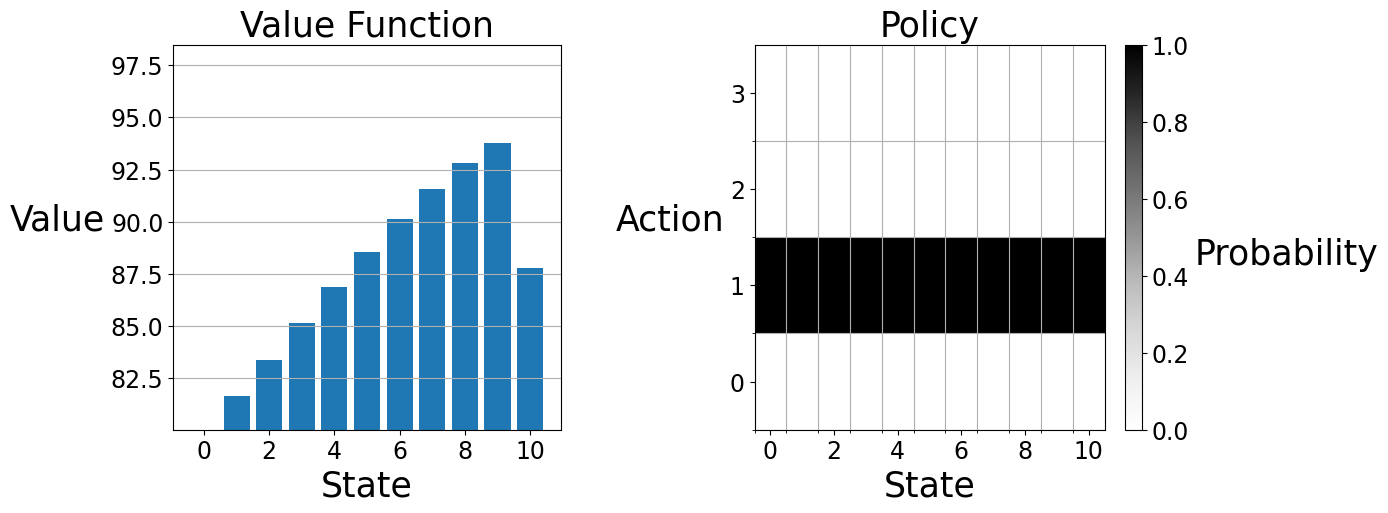

In [22]:
# lock
plot(V, city_policy)

Observe that the value function qualitatively resembles the city council's preferences &mdash; it monotonically increases as more parking is used, until there is no parking left, in which case the value is lower. Because of the relatively simple reward function (more reward is accrued when many but not all parking spots are taken and less reward is accrued when few or all parking spots are taken) and the highly stochastic dynamics function (each state has positive probability of being reached each time step) the value functions of most policies will qualitatively resemble this graph. However, depending on the intelligence of the policy, the scale of the graph will differ. In other words, better policies will increase the expected return at every state rather than changing the relative desirability of the states. Intuitively, the value of a less desirable state can be increased by making it less likely to remain in a less desirable state. Similarly, the value of a more desirable state can be increased by making it more likely to remain in a more desirable state. That is to say, good policies are policies that spend more time in desirable states and less time in undesirable states. As we will see in this assignment, such a steady state distribution is achieved by setting the price to be low in low occupancy states (so that the occupancy will increase) and setting the price high when occupancy is high (so that full occupancy will be avoided).

## Section 2: Policy Iteration
Now the city council would like you to compute a more efficient policy using policy iteration. Policy iteration works by alternating between evaluating the existing policy and making the policy greedy with respect to the existing value function. We have written an outline of the policy iteration algorithm described in chapter 4.3 of the textbook. We will make use of the policy evaluation algorithm you completed in section 1. It is left to you to fill in the `q_greedify_policy` function, such that it modifies the policy at $s$ to be greedy with respect to the q-values at $s$, to complete the policy improvement algorithm.

In [23]:
def improve_policy(env, V, pi, gamma):
    policy_stable = True
    for s in env.S:
        old = pi[s].copy()
        q_greedify_policy(env, V, pi, s, gamma)
        
        if not np.array_equal(pi[s], old):
            policy_stable = False
            
    return pi, policy_stable

def policy_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    policy_stable = False
    
    while not policy_stable:
        V = evaluate_policy(env, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(env, V, pi, gamma)
        
    return V, pi

In [24]:
# -----------
# Graded Cell
# -----------
def q_greedify_policy(env, V, pi, s, gamma):
    """Mutate ``pi`` to be greedy with respect to the q-values induced by ``V``."""
    # YOUR CODE HERE
    A = np.zeros(len(env.A))
    for action in env.A:
        transitions = env.transitions(s, action)
        #print("transitionns:{transitions}")
        for sp, (r, p) in enumerate(transitions):
            #print(f"p(s_prime={sp}, R={r} | s={s} A={action}) transition= {p.round(2)} v[s]:{V[s]} v[sp]:{V[sp]}")
            A[action] += p * (r + gamma * V[sp])
    #print(f"A after LOOP:{A}")
    best_action = np.argmax(A)
    #print(f"best_action:{best_action}")
    pi[s] = np.eye(len(env.A))[best_action]
    

In [26]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

gamma = 0.9
theta = 0.1
env = ParkingWorld(num_spaces=6, num_prices=4)

V = np.array([7, 6, 5, 4, 3, 2, 1])
pi = np.ones((7, 4)) / 4
print(f"pi:{pi}")
new_pi, stable = improve_policy(env, V, pi, gamma)

# expect first call to greedify policy
expected_pi = np.array([
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
])
assert np.all(new_pi == expected_pi)
assert stable == False

# the value function has not changed, so the greedy policy should not change
new_pi, stable = improve_policy(env, V, new_pi, gamma)

assert np.all(new_pi == expected_pi)
assert stable == True

pi:[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


In [29]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.
gamma = 0.9
theta = 0.1
env = ParkingWorld(num_spaces=10, num_prices=4)

V, pi = policy_iteration(env, gamma, theta)

V_answer = [81.60, 83.28, 85.03, 86.79, 88.51, 90.16, 91.70, 93.08, 94.25, 95.25, 89.45]
pi_answer = [
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
]

# make sure value function is within 2 decimal places of answer
#assert grader.near(V, V_answer, 1e-2)
# make sure policy is exactly correct
assert np.all(pi == pi_answer)

When you are ready to test the policy iteration algorithm, run the cell below.

In [31]:
env = ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)

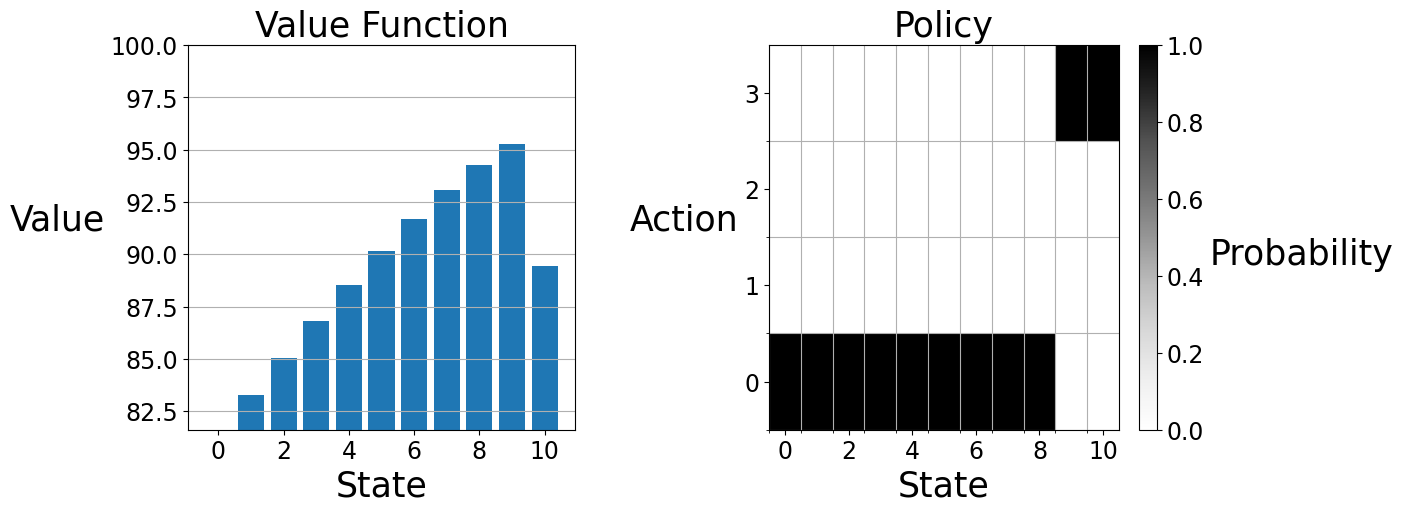

In [32]:
plot(V, pi)

You can check the value function (rounded to one decimal place) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        81.6 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        83.3 $\quad\quad\;$ 0<br>
2 $\quad\quad\quad\;$        85.0 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        86.8 $\quad\quad\;$ 0<br>
4 $\quad\quad\quad\;$        88.5 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        90.2 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        91.7 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        93.1 $\quad\quad\;$ 0<br>
8 $\quad\quad\quad\;$        94.3 $\quad\quad\;$ 0<br>
9 $\quad\quad\quad\;$        95.3 $\quad\quad\;$ 3<br>
10 $\quad\quad\;\;\,\,$      89.5 $\quad\quad\;$ 3<br>

## Section 3: Value Iteration
The city has also heard about value iteration and would like you to implement it. Value iteration works by iteratively applying the Bellman optimality equation for $v_{\ast}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \max_a \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$
We have written an outline of the value iteration algorithm described in chapter 4.4 of the textbook. It is left to you to fill in the `bellman_optimality_update` function to complete the value iteration algorithm.

In [34]:
def value_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_optimality_update(env, V, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    for s in env.S:
        q_greedify_policy(env, V, pi, s, gamma)
    return V, pi

In [35]:
# -----------
# Graded Cell
# -----------
def bellman_optimality_update(env, V, s, gamma):
    """Mutate ``V`` according to the Bellman optimality update equation."""
    # YOUR CODE HERE
    v = np.zeros(len(env.A))
    for action in env.A:
        transitions = env.transitions(s, action)
        #print("transitionns:{transitions}")
        for sp, (r, p) in enumerate(transitions):
            #print(f"p(s_prime={sp}, R={r} | s={s} A={action}) transition= {p.round(2)} v[s]:{V[s]} v[sp]:{V[sp]}")
            v[action] += p * (r + gamma * V[sp])
    V[s] = np.max(v)

In [36]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

gamma = 0.9
env = ParkingWorld(num_spaces=6, num_prices=4)

V = np.array([7, 6, 5, 4, 3, 2, 1])

# only state 0 updated
bellman_optimality_update(env, V, 0, gamma)
assert list(V) == [5, 6, 5, 4, 3, 2, 1]

# only state 2 updated
bellman_optimality_update(env, V, 2, gamma)
assert list(V) == [5, 6, 7, 4, 3, 2, 1]

In [37]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.
gamma = 0.9
env = ParkingWorld(num_spaces=10, num_prices=4)

V = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

for _ in range(10):
    for s in env.S:
        bellman_optimality_update(env, V, s, gamma)

# make sure value function is exactly correct
answer = [61, 63, 65, 67, 69, 71, 72, 74, 75, 76, 71]
assert np.all(V == answer)

When you are ready to test the value iteration algorithm, run the cell below.

In [38]:
env = ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration(env, gamma, theta)

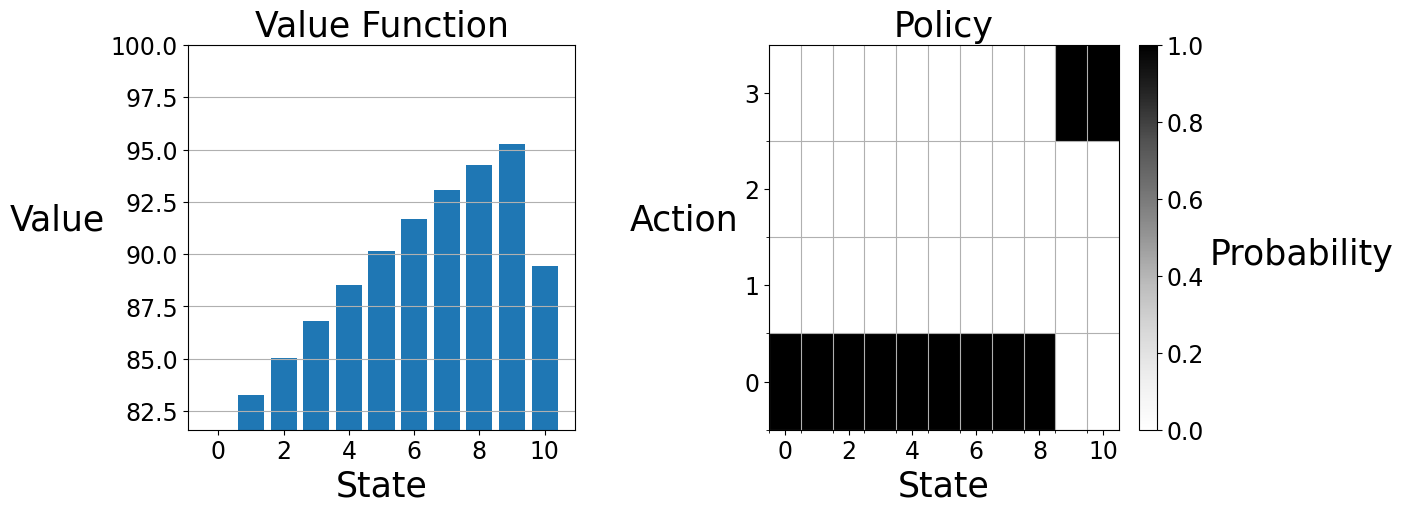

In [39]:
plot(V, pi)

You can check your value function (rounded to one decimal place) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        81.6 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        83.3 $\quad\quad\;$ 0<br>
2 $\quad\quad\quad\;$        85.0 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        86.8 $\quad\quad\;$ 0<br>
4 $\quad\quad\quad\;$        88.5 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        90.2 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        91.7 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        93.1 $\quad\quad\;$ 0<br>
8 $\quad\quad\quad\;$        94.3 $\quad\quad\;$ 0<br>
9 $\quad\quad\quad\;$        95.3 $\quad\quad\;$ 3<br>
10 $\quad\quad\;\;\,\,$      89.5 $\quad\quad\;$ 3<br>

In the value iteration algorithm above, a policy is not explicitly maintained until the value function has converged. Below, we have written an identically behaving value iteration algorithm that maintains an updated policy. Writing value iteration in this form makes its relationship to policy iteration more evident. Policy iteration alternates between doing complete greedifications and complete evaluations. On the other hand, value iteration alternates between doing local greedifications and local evaluations.

In [40]:
def value_iteration2(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            q_greedify_policy(env, V, pi, s, gamma)
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V, pi

You can try the second value iteration algorithm by running the cell below.

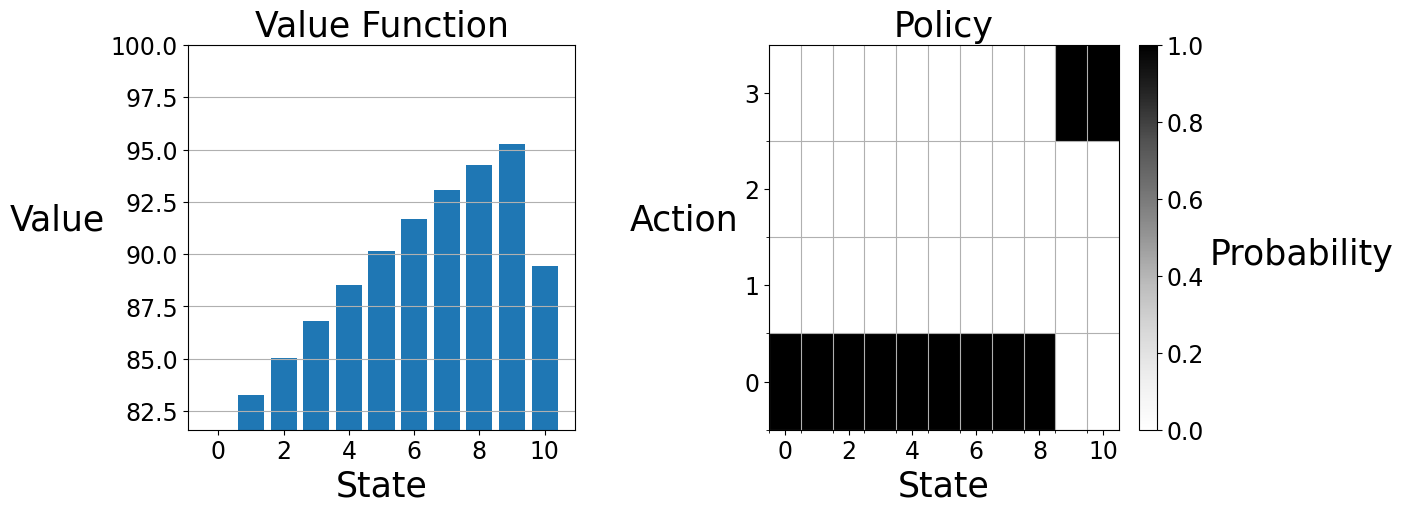

In [41]:
env = ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration2(env, gamma, theta)
plot(V, pi)

## Wrapping Up
Congratulations, you've completed assignment 2! In this assignment, we investigated policy evaluation and policy improvement, policy iteration and value iteration, and Bellman updates. Gridworld City thanks you for your service!